In [1]:
import pandas as pd
import requests
import zipfile
import io
import os
import csv
import ctypes as ct
import numpy as np
from collections import Counter
import matplotlib.pyplot as plt
import re


- "https://www.bankofengland.co.uk/-/media/boe/files/markets/asset-purchase-facility/gilt-purchase-operational-results.xlsx"
- "https://www.bankofengland.co.uk/-/media/boe/files/markets/asset-purchase-facility/gilt-sales-time-series.xlsx"

In [2]:
df_buy = pd.ExcelFile("downloads/gilt-purchase-operational-results.XLSX")

In [3]:
df_buy.sheet_names

['APF Gilts']

In [4]:
df_buy = pd.read_excel("downloads/gilt-purchase-operational-results.XLSX", sheet_name="APF Gilts", header=1)

In [5]:
df_buy.columns

Index(['Operation date', 'Settlement date', 'ISIN', 'Bond\n',
       'Total offers received (proceeds £mn)',
       'Total allocation (proceeds £mn)', 'Total allocation (nominal £mn)',
       'Allocation of which non-competitive (nominal £mn)',
       'Weighted Average Accepted Yield (%)',
       'Weighted Average Accepted Price', 'Highest accepted price',
       'Allocated at highest price (%)', 'Lowest accepted price', 'Tail\n',
       'Comments'],
      dtype='object')

In [6]:
df_boe = df_buy[['Operation date','Total allocation (proceeds £mn)', 'Total allocation (nominal £mn)']].copy()

In [7]:
df_boe['Operation date'] = pd.to_datetime(df_boe['Operation date'], format='%d-%m-%Y')

In [8]:
df_boe.set_index('Operation date', inplace=True)

<Axes: xlabel='Operation date'>

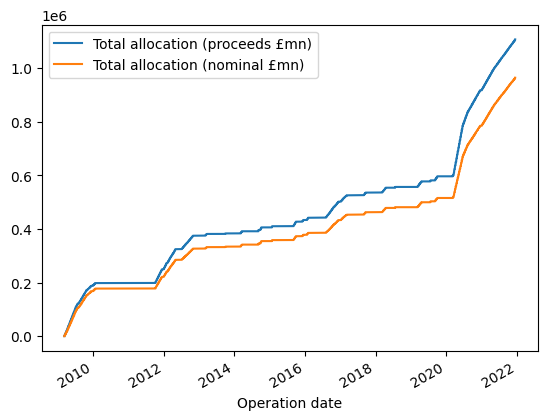

In [9]:
df_boe.cumsum(axis=0).plot()

In [10]:
df_sell = pd.ExcelFile("downloads/gilt-sales-time-series.XLSX")

In [11]:
df_sell.sheet_names

['APF gilt sales']

In [12]:
df_sell = pd.read_excel("downloads/gilt-sales-time-series.XLSX", sheet_name="APF gilt sales", header=1)

In [13]:
df_sell.columns

Index(['Unnamed: 0', 'Operation date', 'Settlement date', 'ISIN', 'Bond\n',
       'Total offers received (proceeds £mn)',
       'Total allocation (proceeds £mn)', 'Total allocation (nominal £mn)',
       'Weighted Average Accepted Yield (%)',
       'Weighted Average Accepted Price', 'Highest accepted price',
       'Allocated at lowest price (%)', 'Lowest accepted price', 'Tail\n'],
      dtype='object')

<Axes: xlabel='Operation date'>

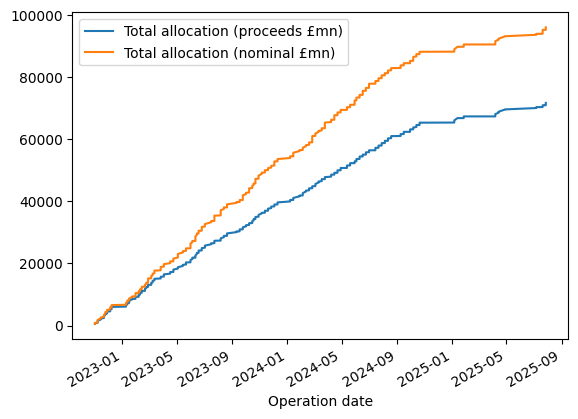

In [14]:
df_boe_exit = df_sell[['Operation date','Total allocation (proceeds £mn)', 'Total allocation (nominal £mn)']].copy()
df_boe_exit['Operation date'] = pd.to_datetime(df_boe_exit['Operation date'], format='%d-%m-%Y')
df_boe_exit.set_index('Operation date', inplace=True)
df_boe_exit.cumsum(axis=0).plot()

In [15]:
bonds = df_buy[['ISIN','Bond\n']].drop_duplicates()

In [16]:
from collections import defaultdict
isin_bond_map = defaultdict(list)
for row in bonds.itertuples():
    isin_bond_map[row.ISIN].append(row._2)
for isin, bond in isin_bond_map.items():
    if len(bond) > 1:
        raise Exception(f"There are duplicates in the BoE list: {isin}")
isin_bond_map['GB0008881541']

['UKT_8_071215']

In [17]:
gilt_level_buys = df_buy[[
    'ISIN',
    'Operation date',
    'Total allocation (proceeds £mn)',
    'Total allocation (nominal £mn)'
    ]].copy()
gilt_level_buys.set_index('Operation date', inplace=True)
gilt_level_buys.index = pd.to_datetime(gilt_level_buys.index, format='%d-%m-%Y').to_period('M').to_timestamp('M')
gilt_level_buys.reset_index(inplace=True)


In [18]:
gilt_buys_ts = gilt_level_buys.pivot_table(
    index='Operation date', 
    columns='ISIN', 
    values='Total allocation (nominal £mn)', aggfunc='sum')

In [19]:
gilt_buys_ts.columns

Index(['GB0002404191', 'GB0004893086', 'GB0008881541', 'GB0008921883',
       'GB0008931148', 'GB0009997999', 'GB0030880693', 'GB0031829509',
       'GB0032452392', 'GB0033280339', 'GB00B00NY175', 'GB00B058DQ55',
       'GB00B06YGN05', 'GB00B0V3WX43', 'GB00B128DP45', 'GB00B16NNR78',
       'GB00B1VWPC84', 'GB00B1VWPJ53', 'GB00B24FF097', 'GB00B29WRG55',
       'GB00B39R3707', 'GB00B39R3F84', 'GB00B3KJDQ49', 'GB00B3KJDS62',
       'GB00B3KJDW09', 'GB00B3QCG246', 'GB00B3Z3K594', 'GB00B4LFZR36',
       'GB00B4RMG977', 'GB00B4YRFP41', 'GB00B52WS153', 'GB00B54QLM75',
       'GB00B582JV65', 'GB00B6460505', 'GB00B6RNH572', 'GB00B7F9S958',
       'GB00B7L9SL19', 'GB00B7Z53659', 'GB00B84Z9V04', 'GB00B8KP6M44',
       'GB00BBJNQY21', 'GB00BD0PCK97', 'GB00BD0XH204', 'GB00BDCHBW80',
       'GB00BDRHNP05', 'GB00BDV0F150', 'GB00BF0HZ991', 'GB00BFMCN652',
       'GB00BFWFPL34', 'GB00BFWFPP71', 'GB00BFX0ZL78', 'GB00BHBFH458',
       'GB00BJLR0J16', 'GB00BJMHB534', 'GB00BJQWYH73', 'GB00BK5CVX03',
      

In [20]:
gilt_buys_ts = gilt_buys_ts.fillna(0).cumsum()
gilt_buys_ts.head()
# TODO: Clip once the Bond has matured

ISIN,GB0002404191,GB0004893086,GB0008881541,GB0008921883,GB0008931148,GB0009997999,GB0030880693,GB0031829509,GB0032452392,GB0033280339,...,GB00BMGR2916,GB00BN65R198,GB00BN65R313,GB00BNNGP668,GB00BNNGP775,GB00BTHH2R79,GB00BYY5F581,GB00BYYMZX75,GB00BYZW3G56,GB00BZB26Y51
Operation date,,,,,,,,,,,,,,,,,,,,,
2009-03-31,405.1,347.0,1349.0,0.0,665.0,1493.8,633.0,1611.0,0.0,531.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2009-04-30,937.1,1262.0,2458.0,0.0,1484.0,5604.6,1739.0,5704.0,0.0,2364.3,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2009-05-31,1741.1,3506.6,2693.0,0.0,1741.0,8013.2,2650.0,9117.1,0.0,4791.8,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2009-06-30,2355.1,6324.6,3303.0,0.0,2122.0,11284.8,3140.0,12106.2,0.0,8781.8,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2009-07-31,3128.1,7263.6,3890.9,0.0,2475.0,11284.8,3975.0,12106.2,0.0,11561.9,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [21]:
gilt_buys_total = gilt_level_buys.reset_index().groupby([ 'ISIN']).agg(
    Total_Allocation_Proceeds=('Total allocation (proceeds £mn)', 'sum'),
    Total_Allocation_Nominal=('Total allocation (nominal £mn)', 'sum'),
    Last_Purchase_Month=('Operation date', 'max')
)
gilt_buys_total.reset_index(inplace=True)
gilt_buys_total.head()
    

,ISIN,Total_Allocation_Proceeds,Total_Allocation_Nominal,Last_Purchase_Month
0,GB0002404191,11893.528404,8906.5,2016-10-31
1,GB0004893086,24839.110612,21081.2,2020-10-31
2,GB0008881541,6266.558482,4715.9,2012-04-30
3,GB0008921883,1912.948123,1556.9,2010-01-31
4,GB0008931148,6513.150546,4575.5,2014-03-31


In [22]:
from bgs.load_gilt_details import load_csv_blocks
details = load_csv_blocks("downloads/BGSDetails.csv")

In [23]:
conv_details = details['Conventionals']

In [24]:
conv_details.columns

Index(['Sequence', 'Inst Code', 'Sedol', 'ISIN Code', '%', 'Stock', 'Suffix',
       'Special features', 'First year', 'Last year', 'Issue date',
       'First coupon payable on date', 'Earliest redemption date',
       'Latest redemption date', 'A (B, C ...) stock merged on date',
       'Actually redeemed or amalgamated', 'Frequency', 'Payment date 1',
       'Payment date 2', 'Payment date 3', 'Payment date 4', 'First coupon',
       'Last coupon', 'Col for I-L 1', 'Col for I-L 2', 'Col for I-L 3',
       'Col for I-L 4', 'Col for I-L 5', 'Number of calls', 'Call payment 1',
       'due on 1', 'Call payment 2', 'due on 2', 'Call payment 3', 'due on 3',
       'Call payment 4', 'due on 4'],
      dtype='object')

In [25]:
conv_details.head()

,Sequence,Inst Code,Sedol,ISIN Code,%,Stock,Suffix,Special features,First year,Last year,...,Col for I-L 5,Number of calls,Call payment 1,due on 1,Call payment 2,due on 2,Call payment 3,due on 3,Call payment 4,due on 4
0,100,4HCV64,,,4.5,Conversion,,,,1964,...,,,,,,,,,,
1,200,2HEX6364,,,2.5,Exchequer,,,1963,1964,...,,,,,,,,,,
2,300,4TY65,,,4,Treasury,,,,1965,...,,,,,,,,,,
3,400,3SB5565,,,3,Savings bonds,,,1955,1965,...,,,,,,,,,,
4,500,5HEX66,,,5.5,Exchequer,,,,1966,...,,,,,,,,,,


In [26]:
conv_details.replace(to_replace=32112, value=32120, inplace=True)

In [27]:
conv_details[conv_details['Sequence']== '32120']

,Sequence,Inst Code,Sedol,ISIN Code,%,Stock,Suffix,Special features,First year,Last year,...,Col for I-L 5,Number of calls,Call payment 1,due on 1,Call payment 2,due on 2,Call payment 3,due on 3,Call payment 4,due on 4
372,32120,4ATG29,BQC82B8,GB00BQC82B83,4.125,Treasury gilt,,,,2029,...,,,,,,,,,,


In [28]:
isin_bond_details = conv_details[['ISIN Code', 'Latest redemption date','%','Sequence']].copy()

In [29]:
[x for x in gilt_buys_total['ISIN'] if x not in isin_bond_details['ISIN Code'].to_list()]

[]

In [30]:
gilt_buys_total['ISIN'][0]

'GB0002404191'

In [31]:
isin_bond_details[isin_bond_details['ISIN Code']=='GB0002404191']['Latest redemption date'].values[0]

'7 Dec 2028'

In [32]:
gilt_buys_total['maturity_date'] = gilt_buys_total['ISIN'].map(
    lambda x: isin_bond_details[
        isin_bond_details['ISIN Code']==x
        ]['Latest redemption date'].values[0]
    )
gilt_buys_total['bgs_id'] = gilt_buys_total['ISIN'].map(
    lambda x: isin_bond_details[
        isin_bond_details['ISIN Code']==x
        ]['Sequence'].values[0]
    )

In [33]:
gilt_buys_total['maturity_date'] = pd.to_datetime(
    gilt_buys_total['maturity_date'], format="%d %b %Y"
)

In [34]:
bond_sales = df_sell[['ISIN','Bond\n']].drop_duplicates()

In [35]:
isin_bond_sales_map = defaultdict(list)
for row in bond_sales.itertuples():
    isin_bond_sales_map[row.ISIN].append(row._2)
for isin, bond in isin_bond_sales_map.items():
    if len(bond) > 1:
        raise Exception(f"There are duplicates in the BoE list: {isin}")
isin_bond_sales_map['GB0008881541']

[]

In [36]:
gilt_level_sales = df_sell[[
    'ISIN',
    'Operation date',
    'Total allocation (proceeds £mn)',
    'Total allocation (nominal £mn)'
    ]].copy()
gilt_level_sales.set_index('Operation date', inplace=True)
gilt_level_sales.index = pd.to_datetime(gilt_level_sales.index, format='%d-%m-%Y').to_period('M').to_timestamp('M')
gilt_level_sales.reset_index(inplace=True)
gilt_level_sales.head()

,Operation date,ISIN,Total allocation (proceeds £mn),Total allocation (nominal £mn)
0,2022-11-30,GB00BL68HJ26,491.108666,545.0
1,2022-11-30,GB00BYZW3G56,0.000000,0.0
2,2022-11-30,GB00BNNGP668,170.287385,192.8
3,2022-11-30,GB00BDRHNP05,45.194932,50.0
4,2022-11-30,GB00B16NNR78,0.000000,0.0


In [37]:
sales_by_isin=gilt_level_sales.groupby('ISIN')[['Total allocation (nominal £mn)', 'Total allocation (proceeds £mn)']].sum().reset_index()

In [38]:
sales_by_isin['maturity_date'] = sales_by_isin['ISIN'].map(
    lambda x: isin_bond_details[
        isin_bond_details['ISIN Code']==x
        ]['Latest redemption date'].values[0]
    )
sales_by_isin['maturity_date'] = pd.to_datetime(
    sales_by_isin['maturity_date'], format="%d %b %Y"
)

In [39]:
matured_sales = sales_by_isin['maturity_date'] > pd.Timestamp('2025-04-30')

In [40]:
matured = gilt_buys_total['maturity_date'] > pd.Timestamp.now()

In [41]:
sales_by_isin[matured_sales].shape, gilt_buys_total[matured].shape

((44, 4), (45, 6))

In [42]:
check_sales = sales_by_isin[matured_sales]['Total allocation (nominal £mn)'].sum()
check_sales

np.float64(96138.2)

In [43]:
unsold = [x for x in gilt_buys_total[matured]['ISIN'].to_list() if x not in sales_by_isin[matured_sales]['ISIN'].to_list()]  
unsold

['GB00BTHH2R79']

In [44]:
conv_details[conv_details['ISIN Code']==unsold[0]].T

,357
Sequence,32025
Inst Code,2TG25
Sedol,BTHH2R7
ISIN Code,GB00BTHH2R79
%,2
Stock,Treasury gilt
Suffix,
Special features,
First year,
Last year,2025


In [45]:
boe_portfolio = gilt_buys_total[matured].set_index('ISIN').merge(
    sales_by_isin[matured_sales][[
        'ISIN',
        'Total allocation (nominal £mn)',
        'Total allocation (proceeds £mn)'
        ]].set_index('ISIN'),
        how='left',
        left_index=True,
        right_index=True,
        suffixes=('_buy', '_sell')
        ).copy().fillna(0).reset_index()

In [46]:
boe_portfolio.head()

,ISIN,Total_Allocation_Proceeds,Total_Allocation_Nominal,Last_Purchase_Month,maturity_date,bgs_id,Total allocation (nominal £mn),Total allocation (proceeds £mn)
0,GB0002404191,11893.528404,8906.5,2016-10-31,2028-12-07,32100,676.0,753.199412
1,GB0004893086,24839.110612,21081.2,2020-10-31,2032-06-07,32200,2722.5,2870.723138
2,GB0032452392,19803.081357,14928.9,2021-12-31,2036-03-07,32210,5491.3,5597.317757
3,GB00B00NY175,14736.342683,11492.7,2021-12-31,2038-12-07,32220,1142.1,1209.164545
4,GB00B06YGN05,13593.064359,10407.4,2021-12-31,2055-12-07,32270,745.0,668.174028


In [47]:
boe_portfolio[boe_portfolio['ISIN']==unsold[0]]

,ISIN,Total_Allocation_Proceeds,Total_Allocation_Nominal,Last_Purchase_Month,maturity_date,bgs_id,Total allocation (nominal £mn),Total allocation (proceeds £mn)
41,GB00BTHH2R79,28331.999026,26198.3,2020-06-30,2025-09-07,32025,0.0,0.0


In [48]:
assert boe_portfolio['Total allocation (nominal £mn)'].sum() == check_sales

In [49]:
boe_portfolio['current_position'] = boe_portfolio['Total_Allocation_Nominal'] - boe_portfolio['Total allocation (nominal £mn)']
boe_portfolio['position_cost'] = boe_portfolio['Total_Allocation_Proceeds'] - boe_portfolio['Total allocation (proceeds £mn)']

In [50]:
boe_portfolio['Coupon']=boe_portfolio['ISIN'].map(
    lambda x: isin_bond_details[
        isin_bond_details['ISIN Code']==x
        ]['%'].values[0]
    )

<Axes: title={'center': 'BoE Portfolio by Coupon'}, xlabel='Coupon'>

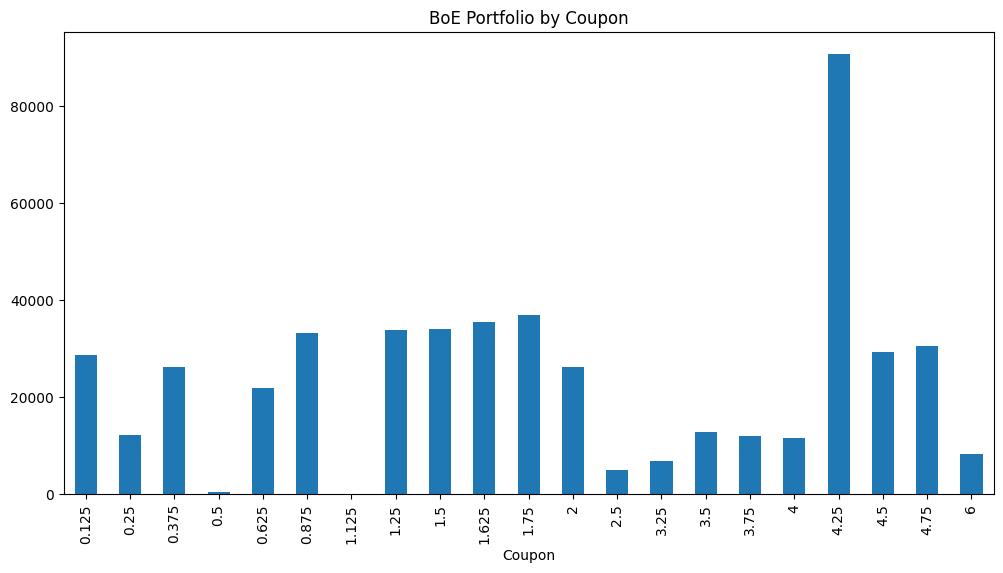

In [51]:
boe_portfolio.groupby('Coupon')['current_position'].sum().plot(
    kind='bar', figsize=(12, 6), title='BoE Portfolio by Coupon'
)

In [52]:
boe_portfolio.groupby('Coupon')['position_cost'].sum().cumsum()

Coupon
0.125     29631.340781
0.25      41428.673191
0.375     68743.091449
0.5       72947.511348
0.625     99012.784888
0.875    134130.592946
1.125    134562.469275
1.25     173209.190555
1.5      210542.504671
1.625    260218.156429
1.75     308820.723825
2        337152.722851
2.5      345640.135293
3.25     355370.724572
3.5      376930.854593
3.75     394292.281071
4        411821.085735
4.25     529338.688505
4.5      570215.251236
4.75     611229.801775
6        622370.130767
Name: position_cost, dtype: float64

In [53]:
from bgs.load_bgs_prices import load_prices
price_df=load_prices("downloads/BGSPrices.csv")

In [54]:
price_df.index = pd.to_datetime(price_df.index, format="%d %b %Y").to_period('M').to_timestamp('M')

In [55]:
price_df.loc['Apr 2025',32100]

2025-04-30    108.018
Freq: ME, Name: 32100, dtype: object

In [56]:
boe_portfolio['mkt_price'] = boe_portfolio['bgs_id'].map(
    lambda x: price_df.loc['Apr 2025', int(x)].values[0])

In [57]:
boe_portfolio.head()

,ISIN,Total_Allocation_Proceeds,Total_Allocation_Nominal,Last_Purchase_Month,maturity_date,bgs_id,Total allocation (nominal £mn),Total allocation (proceeds £mn),current_position,position_cost,Coupon,mkt_price
0,GB0002404191,11893.528404,8906.5,2016-10-31,2028-12-07,32100,676.0,753.199412,8230.5,11140.328992,6,108.018
1,GB0004893086,24839.110612,21081.2,2020-10-31,2032-06-07,32200,2722.5,2870.723138,18358.7,21968.387474,4.25,101.061
2,GB0032452392,19803.081357,14928.9,2021-12-31,2036-03-07,32210,5491.3,5597.317757,9437.6,14205.763600,4.25,97.630
3,GB00B00NY175,14736.342683,11492.7,2021-12-31,2038-12-07,32220,1142.1,1209.164545,10350.6,13527.178138,4.75,100.290
4,GB00B06YGN05,13593.064359,10407.4,2021-12-31,2055-12-07,32270,745.0,668.174028,9662.4,12924.890331,4.25,85.580


In [58]:
boe_portfolio['p&l'] = boe_portfolio['mkt_price'] * boe_portfolio['current_position']/100 - boe_portfolio['position_cost']  

In [59]:
boe_portfolio['p&l'].sum()

np.float64(-199169.4263469985)

<Axes: title={'center': 'BoE Portfolio Loses by Coupon'}, xlabel='Coupon'>

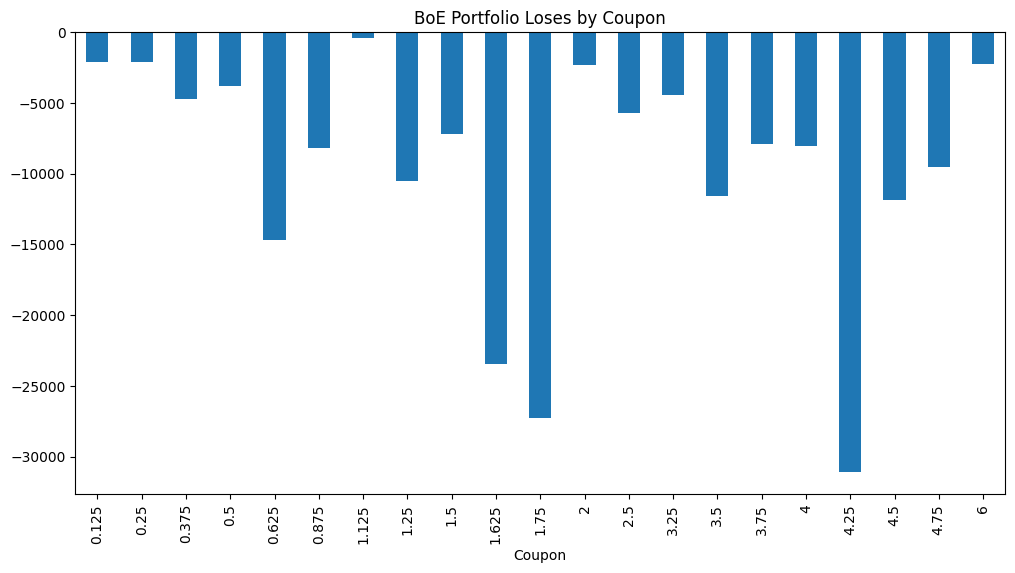

In [60]:
boe_portfolio.groupby('Coupon')['p&l'].sum().plot(
    kind='bar', figsize=(12, 6), title='BoE Portfolio Loses by Coupon'
)

In [61]:
boe_portfolio.groupby('Coupon')['p&l'].sum().cumsum()

Coupon
0.125     -2116.750214
0.25      -4210.397563
0.375     -8931.340705
0.5      -12752.650094
0.625    -27440.612834
0.875    -35631.723594
1.125    -36063.599923
1.25     -46604.668233
1.5      -53788.635605
1.625    -77222.706763
1.75    -104474.010179
2       -106800.528693
2.5     -112510.107315
3.25    -116934.292304
3.5     -128489.657305
3.75    -136401.070103
4       -144461.891767
4.25    -175545.217762
4.5     -187407.643181
4.75    -196919.518845
6       -199169.426347
Name: p&l, dtype: float64

In [62]:
from bgs.load_bgs_amounts import load_bgs_amounts
tables = load_bgs_amounts("downloads/BGSAmounts.csv")

In [63]:
conv_amt = tables['Conventionals']

In [64]:
conv_amt.loc['30 Apr 2025','32100']

'20730.555'

In [65]:
boe_portfolio['tot_outstanding'] = boe_portfolio['bgs_id'].map(
    lambda x: conv_amt.loc['30 Apr 2025', x])

In [66]:
boe_portfolio.head()

,ISIN,Total_Allocation_Proceeds,Total_Allocation_Nominal,Last_Purchase_Month,maturity_date,bgs_id,Total allocation (nominal £mn),Total allocation (proceeds £mn),current_position,position_cost,Coupon,mkt_price,p&l,tot_outstanding
0,GB0002404191,11893.528404,8906.5,2016-10-31,2028-12-07,32100,676.0,753.199412,8230.5,11140.328992,6,108.018,-2249.907502,20730.555
1,GB0004893086,24839.110612,21081.2,2020-10-31,2032-06-07,32200,2722.5,2870.723138,18358.7,21968.387474,4.25,101.061,-3414.901667,41276.149
2,GB0032452392,19803.081357,14928.9,2021-12-31,2036-03-07,32210,5491.3,5597.317757,9437.6,14205.763600,4.25,97.630,-4991.834720,32424.933
3,GB00B00NY175,14736.342683,11492.7,2021-12-31,2038-12-07,32220,1142.1,1209.164545,10350.6,13527.178138,4.75,100.290,-3146.561398,27455.903
4,GB00B06YGN05,13593.064359,10407.4,2021-12-31,2055-12-07,32270,745.0,668.174028,9662.4,12924.890331,4.25,85.580,-4655.808411,28320.177


In [67]:
boe_portfolio['pct_ownership']=boe_portfolio['current_position']/boe_portfolio['tot_outstanding'].astype(float).fillna(0)

<Axes: ylabel='Frequency'>

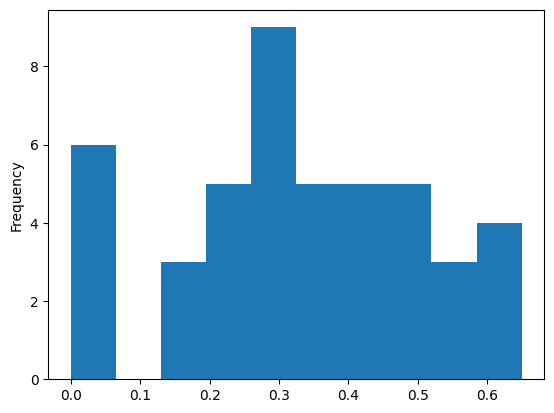

In [68]:
boe_portfolio['pct_ownership'].plot(kind='hist')

<Axes: xlabel='pct_ownership', ylabel='p&l'>

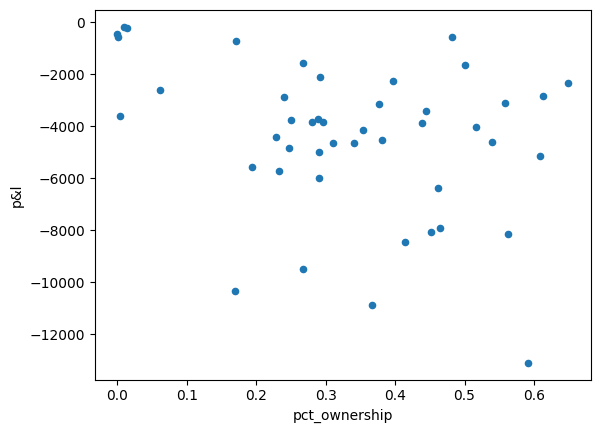

In [69]:
boe_portfolio.plot(x='pct_ownership',y='p&l', kind='scatter')

In [70]:
boe_portfolio[boe_portfolio['pct_ownership']>0.5][['ISIN','p&l', 'pct_ownership']].sort_values(by='p&l', ascending=True)

,ISIN,p&l,pct_ownership
21,GB00BFWFPP71,-13109.010038,0.591512
11,GB00B52WS153,-8132.388021,0.562164
24,GB00BJMHB534,-5163.631162,0.608563
22,GB00BFX0ZL78,-4623.997069,0.538983
26,GB00BL68HH02,-4013.575834,0.516476
19,GB00BDRHNP05,-3090.981267,0.558503
43,GB00BYZW3G56,-2854.351430,0.612852
41,GB00BTHH2R79,-2326.518514,0.649389
6,GB00B16NNR78,-1648.591124,0.500660


In [71]:
conv_details.loc[conv_details['ISIN Code']=='GB00BFWFPP71'].T

,404
Sequence,32257
Inst Code,1TTG49
Sedol,BFWFPP7
ISIN Code,GB00BFWFPP71
%,1.75
Stock,Treasury gilt
Suffix,
Special features,
First year,
Last year,2049


In [78]:
boe_end_purchase_port =  gilt_buys_total.loc[gilt_buys_total['maturity_date'] > gilt_buys_total['Last_Purchase_Month'].max()]

/tmp/ipykernel_9914/881018352.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  boe_end_purchase_port['year'] = boe_end_purchase_port['maturity_date'].dt.year


<Axes: xlabel='year'>

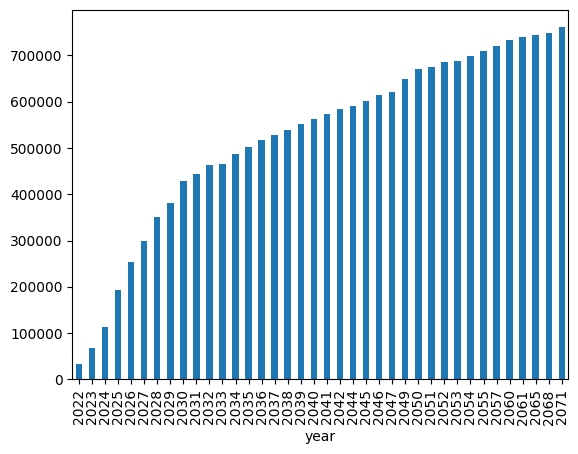

In [83]:
boe_end_purchase_port['year'] = boe_end_purchase_port['maturity_date'].dt.year
boe_end_purchase_port.groupby('year')['Total_Allocation_Nominal'].sum().cumsum().plot(kind='bar', x='year', y='Total_Allocation_Nominal')